# Evaluating model Experiment 4

In [1]:
import numpy as np
import cv2
import caffe
from caffe.proto import caffe_pb2
import lmdb
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib notebook

caffe.set_mode_cpu()

In [2]:
label_value = [
    'basalcellcarcinoma',
    'lentigo',
    'malignantmelanoma',
    'pigmentednevus',
    'seborrheickeratosis',
    'wart'
    ]

## Loading mean image file

In [3]:
path_to_mean_image = '/home/danilo/Documents/FGA/2018-1/TCC1/Datasets/Atlas_5k_lmdb/input/mean.binaryproto'

In [4]:
mean_blobproto_new = caffe.proto.caffe_pb2.BlobProto()
f = open(path_to_mean_image, 'rb')
mean_blobproto_new.ParseFromString(f.read())
mean_image = caffe.io.blobproto_to_array(mean_blobproto_new)
mean_array = np.asarray(mean_blobproto_new.data, dtype=np.float32).reshape(
    (mean_blobproto_new.channels, mean_blobproto_new.height, mean_blobproto_new.width))
f.close()

## Setting up network for inference

In [5]:
deploy_prototxt_file_path = '../ResNet_152_deploy.prototxt'
caffe_model_file_path = './atlas_5k_3_iter_12000.caffemodel'

In [6]:
import os
os.environ['GLOG_minloglevel'] = '2' # suprress Caffe verbose prints

net = caffe.Net(deploy_prototxt_file_path, caffe_model_file_path, caffe.TEST)
print('Imported network')

Imported network


## Defining Metrics

In [7]:
from sklearn import metrics

def display_metrics(t_true, t_pred):
    confusion_matrix = metrics.confusion_matrix(t_true, t_pred)
    report = metrics.classification_report(t_true, t_pred)
    accuracy = metrics.accuracy_score(t_true, t_pred)
    print('Confusion Matrix\n')
    print(confusion_matrix, end='\n\n')
    print(report, end='\n\n')
    print('Accuracy: {:.4f}'.format(accuracy))

## Exporting to CSV

In [8]:
def save_pred_to_csv(csv_path, true_preds):
    with open(csv_path, 'w') as f:
        f.write('true, pred\n')
        for t in true_preds:
            f.write('{},{}\n'.format(str(t[0]), str(t[1])))
    f.close()
    paths = os.path.split(csv_path)
    print('Saved {} to {}'.format(path[1], path[0]))

---

## Validating with lmbd data
### Loading lmdb database 

In [9]:
path_to_lmdb_dataset = '/home/danilo/Documents/FGA/2018-1/TCC1/Datasets/Atlas_5k_lmdb/validation'

In [10]:
lmdb_env = lmdb.open(path_to_lmdb_dataset)
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()

### Testing for LMDB

In [11]:
from collections import defaultdict

count = 0
correct = 0
matrix = defaultdict(int) # (real,pred) -> int
labels_set = set()

test_lmdb = []

for key, value in lmdb_cursor:
    datum = caffe.proto.caffe_pb2.Datum()
    datum.ParseFromString(value)
    
    label = int(datum.label)
    
    image = caffe.io.datum_to_array(datum)
    image = image.astype(np.uint8)
    
    out = net.forward_all(data=np.asarray([image]) - mean_image)
    plabel = int(out['prob'][0].argmax(axis=0))
    probabilities = out['prob'][0]
   
    count += 1
    iscorrect = label == plabel
    correct += (1 if iscorrect else 0)
    
    img = cv2.cvtColor(np.transpose(image, (1,2,0)), cv2.COLOR_BGR2RGB)
    test_lmdb.append((label, plabel, probabilities, img))

    matrix[(label, plabel)] += 1
    labels_set.update([label, plabel])
    
    clear_output(wait=True)
    print("{} images predicted.\tAccuracy: {:.2f}%".format(count, 100.*correct/count))

6000 images predicted.	Accuracy: 96.62%


### Persistence with pickle file

In [12]:
# import pickle
# with open('test_lmdb.pickle', 'wb') as f:
#     pickle.dump(test_lmdb, f)
#     f.close()

In [9]:
import pickle
with open('test_lmdb.pickle', 'rb') as f:
     test_lmdb = pickle.load(f)

### Exploring results on the model

In [10]:
def get_correct_predictions(is_correct, dataset):
    values = np.array([i if (t[0]==t[1])==is_correct else 0 for i, t in enumerate(dataset)])
    values_index, = np.where(values > 0)
    results_values = [dataset[i] for i in values_index]
    
    return results_values

In [54]:
def get_n_values(values, n=0, delta=0.2, desc=False):
    undecideds = []
    if n == 0:
        n == len(values)
        
    for value in values:
        probabilities = value[2]
        probas_desc = sorted(probabilities, reverse=True)
        f_label = np.where(probabilities == probas_desc[0])[0][0]
        s_label = np.where(probabilities == probas_desc[1])[0][0]
        difference = probas_desc[0] - probas_desc[1]

        if difference <= delta:
            img = value[3]
            caption_1 = 'True was {}/{:.2f}, but juged as {}/{:.2f}.'.format(label_value[value[0]],
                                                         probabilities[value[0]],
                                                         label_value[value[1]],
                                                         probabilities[value[1]]
                                                        )
            caption_2 = 'Undecised between {}/{:.2f} and {}/{:.2f}, with a certanty of {:.2f}%.'.format(label_value[f_label],
                                                              probabilities[f_label],
                                                              label_value[s_label],
                                                              probabilities[s_label],
                                                              difference * 100 
                                                             )
            undecideds.append((difference, img, caption_1, caption_2))
    
    undecideds_sorted = sorted(undecideds, key=lambda u: u[0], reverse=desc)
    
    for i, undecided in enumerate(undecideds_sorted):
        if i >= n:
            break
        plt.imshow(undecided[1])
        plt.show()
        print(undecided[2])
        print(undecided[3])

### Ploting Most Uncertain images

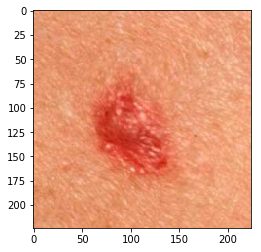

True was basalcellcarcinoma/0.50, but juged as malignantmelanoma/0.50.
Undecised between malignantmelanoma/0.50 and basalcellcarcinoma/0.50, with a certanty of 0.40%.


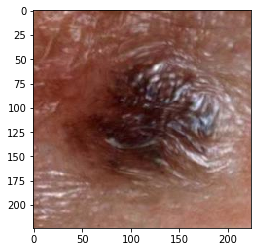

True was basalcellcarcinoma/0.35, but juged as pigmentednevus/0.36.
Undecised between pigmentednevus/0.36 and basalcellcarcinoma/0.35, with a certanty of 1.05%.


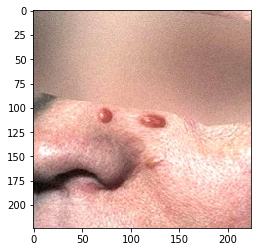

True was pigmentednevus/0.00, but juged as wart/0.43.
Undecised between wart/0.43 and basalcellcarcinoma/0.42, with a certanty of 1.56%.


In [17]:
wrongs_values = get_correct_predictions(False, test_lmdb)

# Undecided decisions
get_n_values(wrongs_values, n=3)

### Most wrong images

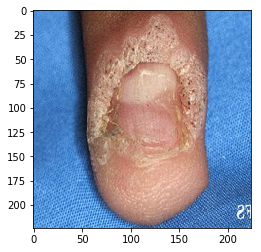

True was wart/0.00, but juged as malignantmelanoma/1.00.
Undecised between malignantmelanoma/1.00 and wart/0.00, with a certanty of 100.00%.


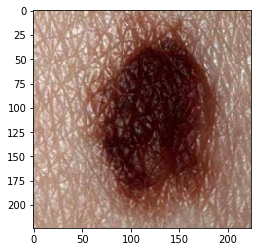

True was seborrheickeratosis/0.00, but juged as pigmentednevus/1.00.
Undecised between pigmentednevus/1.00 and seborrheickeratosis/0.00, with a certanty of 100.00%.


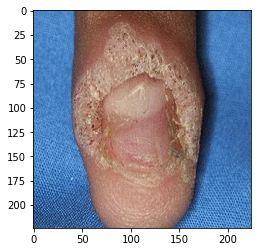

True was wart/0.00, but juged as malignantmelanoma/1.00.
Undecised between malignantmelanoma/1.00 and wart/0.00, with a certanty of 100.00%.


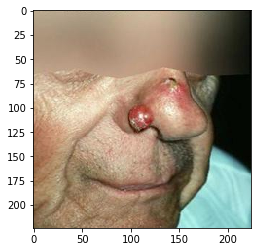

True was basalcellcarcinoma/0.00, but juged as malignantmelanoma/1.00.
Undecised between malignantmelanoma/1.00 and basalcellcarcinoma/0.00, with a certanty of 100.00%.


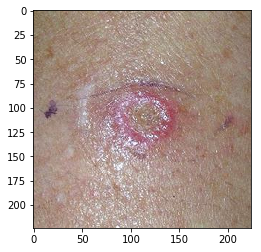

True was basalcellcarcinoma/0.00, but juged as wart/1.00.
Undecised between wart/1.00 and basalcellcarcinoma/0.00, with a certanty of 100.00%.


In [18]:
get_n_values(wrongs_values, n=5, delta=1, desc=True)

## Testing for Edinburgh

In [12]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
def transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT, equalize=False):

    if equalize:
        # Histogram Equalization
        img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
        img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
        img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

    # Image Resizing
    img = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_CUBIC)

    return img

In [13]:
import os
def read_files_from_dir(path):
    dataset = []
    for r, dirs, files in os.walk(path):
        if len(dirs) > 0:
            labels = dirs
            continue  # use only leaf folders
        files_full_path = ['{}/{}'.format(r, f) for f in files]
        directory_name = r.split(os.path.sep)[-1]
        dataset.append((files_full_path, directory_name))

    test_dataset = [(img, label) for ndataset, label in dataset for img in ndataset]
    
    print('Read {} files'.format(len(test_dataset)))
    return test_dataset

In [55]:
from copy import copy

def make_predictions(test_dataset):
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_mean('data', mean_array)
    transformer.set_transpose('data', (2,0,1))
    
    results = []
    for in_idx, (img_path, label) in enumerate(test_dataset):
        clear_output(wait=True)
        print('Processed {}/{}'.format(in_idx, len(test_dataset)))

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT)

        net.blobs['data'].data[...] = transformer.preprocess('data', img)
        out = net.forward()

        img_id = os.path.sep.join(img_path.split(os.path.sep)[-2:])
        str_label = label
        true_label = label_value.index(str_label)
        
        softmaxwithloss = copy(out['prob'][0])
        predict = softmaxwithloss.argmax()
        
        test = (true_label, predict, softmaxwithloss, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        results.append(test)
    
    return results

In [56]:
edinburgh_path = '../../../../../Datasets/Test/Atlas_fake_edinburgh'
predictions_edimburg = make_predictions(read_files_from_dir(edinburgh_path))

Processed 902/903


In [57]:
# with open('test_edinburgh.pickle', 'wb') as f:
#     pickle.dump(predictions_edimburg, f)
#     f.close()

In [58]:
with open('test_edinburgh.pickle', 'rb') as f:
     predictions_edimburg = pickle.load(f)

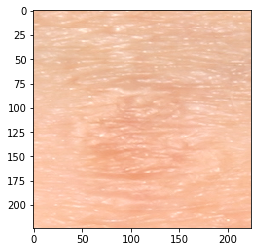

True was seborrheickeratosis/0.00, but juged as wart/1.00.
Undecised between wart/1.00 and seborrheickeratosis/0.00, with a certanty of 100.00%.


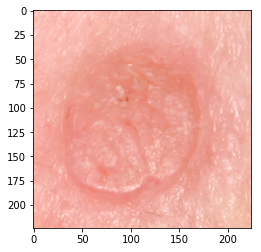

True was seborrheickeratosis/0.00, but juged as wart/1.00.
Undecised between wart/1.00 and basalcellcarcinoma/0.00, with a certanty of 100.00%.


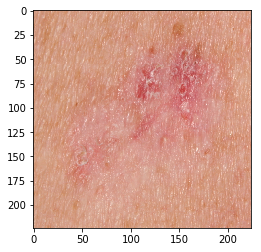

True was basalcellcarcinoma/0.00, but juged as wart/1.00.
Undecised between wart/1.00 and malignantmelanoma/0.00, with a certanty of 100.00%.


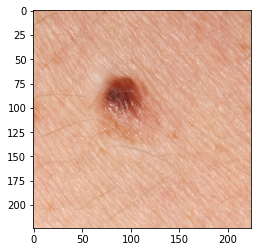

True was malignantmelanoma/0.00, but juged as pigmentednevus/1.00.
Undecised between pigmentednevus/1.00 and basalcellcarcinoma/0.00, with a certanty of 100.00%.


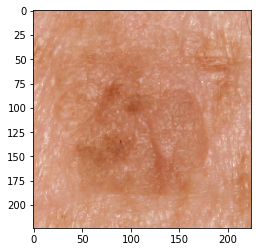

True was seborrheickeratosis/0.00, but juged as lentigo/1.00.
Undecised between lentigo/1.00 and seborrheickeratosis/0.00, with a certanty of 100.00%.


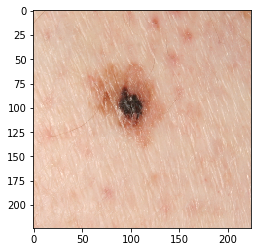

True was malignantmelanoma/0.00, but juged as pigmentednevus/1.00.
Undecised between pigmentednevus/1.00 and seborrheickeratosis/0.00, with a certanty of 100.00%.


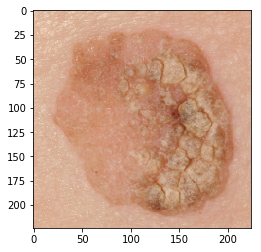

True was seborrheickeratosis/0.00, but juged as wart/1.00.
Undecised between wart/1.00 and seborrheickeratosis/0.00, with a certanty of 100.00%.


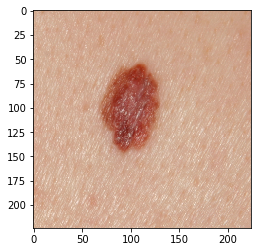

True was malignantmelanoma/0.00, but juged as pigmentednevus/1.00.
Undecised between pigmentednevus/1.00 and malignantmelanoma/0.00, with a certanty of 100.00%.


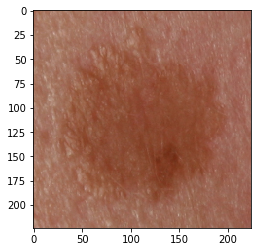

True was seborrheickeratosis/0.00, but juged as pigmentednevus/1.00.
Undecised between pigmentednevus/1.00 and malignantmelanoma/0.00, with a certanty of 100.00%.


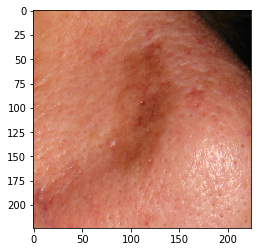

True was malignantmelanoma/0.00, but juged as lentigo/1.00.
Undecised between lentigo/1.00 and basalcellcarcinoma/0.00, with a certanty of 100.00%.


In [62]:
wrongs_edin = get_correct_predictions(False, predictions_edimburg)

# Most wrong
get_n_values(wrongs_edin, n=10, delta=1, desc=True)

---

----

3 3


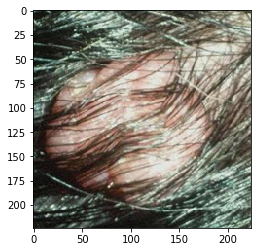

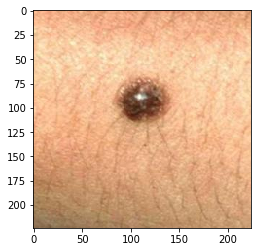

134.25367612035453


array([[0.93739297]])

In [98]:
import math
i = 59
j = 15
oi = np.concatenate(cv2.meanStdDev(cv2.cvtColor(wrongs_values[i][3], cv2.COLOR_RGB2BGR))).flatten()
ola = np.concatenate(cv2.meanStdDev(cv2.cvtColor(wrongs_values[j][3], cv2.COLOR_RGB2BGR))).flatten()
# oi = cv2.calcHist([cv2.cvtColor(wrongs_values[i][3], cv2.COLOR_RGB2BGR)], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()
# ola = cv2.calcHist([cv2.cvtColor(wrongs_values[j][3], cv2.COLOR_RGB2BGR)], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()

from sklearn.metrics.pairwise import cosine_similarity
print(wrongs_values[i][0], wrongs_values[j][0])
plt.imshow(wrongs_values[i][3])
plt.show()
plt.imshow(wrongs_values[j][3])
plt.show()
print(math.sqrt(sum(pow(a-b,2) for a, b in zip(oi, ola))))
cosine_similarity([oi], [ola])

In [91]:
print(d, c[0][2], test_lmdb[28][2])

[0.976828, 0.016480764, 0.006688659, 2.1444957e-06, 4.5379733e-07, 8.36496e-13] [4.5379733e-07 9.7682798e-01 6.6886591e-03 2.1444957e-06 1.6480764e-02
 8.3649602e-13] [4.5379733e-07 9.7682798e-01 6.6886591e-03 2.1444957e-06 1.6480764e-02
 8.3649602e-13]


203

In [26]:
print("\n" + str(correct) + " out of " + str(count) + " were classified correctly")
display_metrics([t[0] for t in test_lmdb], [t[1] for t in test_lmdb])


5797 out of 6000 were classified correctly
Confusion Matrix

[[ 910    4   13   34   23   13]
 [   0  999    0    0    0    0]
 [   1    0 1024    4    2    0]
 [  11    1    6  970   14    2]
 [   9   10    8   39  876    0]
 [   0    2    6    0    1 1018]]

             precision    recall  f1-score   support

          0       0.98      0.91      0.94       997
          1       0.98      1.00      0.99       999
          2       0.97      0.99      0.98      1031
          3       0.93      0.97      0.95      1004
          4       0.96      0.93      0.94       942
          5       0.99      0.99      0.99      1027

avg / total       0.97      0.97      0.97      6000


Accuracy: 0.9662


In [ ]:
csv_path_lmdb = './prediction_eval.csv'
save_pred_to_csv(csv_path_lmdb, test_lmdb)

----

In [ ]:

path_to_dataset_folder = ''